<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Turn a ML research paper into usable code

In this notebook we are going to be replicating the Vision Transformer (ViT)

Paper - https://arxiv.org/abs/2010.11929v2



# Anatomy of a research paper

1. Abstract : An *overview/summary* of the paper
2. Introduction: What is the paper's *main problem* ? And details of previous methods used to try and solve it.
3. Method: What *steps did the researchers take* to solve the problem? (Example: Model, Datasource, training setup)
4. Results: What are the *outcomes* of the paper? If a new type of model training setup was used how did the results compare to previous methods?
5. Conclusion: What are the *limitations* of the suggested methods ? What are the *future work* ?
6. References: What *resources/other papers* did the researchers use to build there own body of work?
7. Appendix: Are there any *extra resources/findings* that were not mentioned in the above section of the paper?


## Why replicate machine learning papers

If you want the skills to be a Machine Learning Engineer here are the steps

1. Download a paper
2. Implement it
3. Keep doing this until you have skills
4. Build infrastructure around your models / data preprocessing steps

## Where can we find machine learning research paper

- [arXiv](https://arxiv.org/)
- [AK](https://twitter.com/_akhaliq)
- [Paper With Code](https://paperswithcode.com/)
- [ViT PyTorch](https://github.com/lucidrains/vit-pytorch)

## What are we going to cover

* Getting setup (importing previously written code)
* Introduce a machien elarning paper replicating with PyTorch
* Replicating ViT for FoodVisionMini
* Training a custom ViWaitingForTextObjectMode
* Feature Extraction with a pretrained ViT




# 0. Get setup

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 4036 (delta 1064), reused 1100 (delta 994), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.60 MiB | 41.43 MiB/s, done.
Resolving deltas: 100% (2357/2357), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

The whole goal of what we are trying to do here is to replicate ViT for our FoodVision Mini problem

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 #Table 3 from the ViT Paper


# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [7]:
# Create a batch size of 32 (the paper is using 4096 but due to hardware limitation we will decrease it)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=manual_transforms
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Vizualize a single image

As always, let's adhere to the moto *visualize, visualize, visualize!*

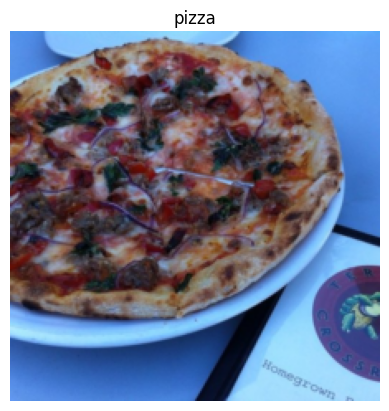

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# Plot the image with myplotlib
plt.imshow(image.permute(1, 2, 0)) # CHW => HWC
plt.axis("off")
plt.title(class_names[label])
plt.show()

## 3. Replicating ViT: Overview

Looking at a whole machine learning paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.


* **Inputs** - What goes into the model? (in our case, image tensor)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classificiation label)
* **Layers** - Takes an input, manipulates it with a function. (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model(Architecture)** - A collection of blocks.

## 3.1 ViT overview: Pieces of the puzzle

* Figure 1: Visual overview of the architrcture
* Four equations: Math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training
* Text

#### Figure 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper" />

* **Embeddings** -  Learnable representation of content(start with random number and improve them over time)

#### Four equations
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper" />

Section 3.1: Describe the various equations

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode ⁉

```python
x_input = [class_token, img_patch_1, img_patch_2...img_patch_N] + [class_token_pos, img_patch_1_pos, img_patch_2_pos,...img_patch_N_pos]
```

---

**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).



```python
# Equation 2

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```
---

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = Multilayer Perceptron = a neural network with x number of layers
* MLP = on hidden layer at training time
* MLP = single linear layer a fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
````
---

#### Table 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper" />

* ViT-Base, ViT-Large, ViT-Huge are all different sizes of the same model architecture
* Layers - the number of transformer encoder layers
* Hidden Size $D$ - the embedding size throught the architecture (each image patch to vector)
* MLP size - the number of hidden units in the MLP
* Heads - number of multi-head self-attention (MSA)
* Params - total number of params in the architecture
---

## 4.Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input => function => output

What's the input shape ?

What's the output shape ?

* Input shape: (224, 224, 3) => Single Image (Hight, Width, Color Channels)
* Output shape: ???

### 4.1 : Calculate input and output shape by hand
**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input Shape: $H\times{W}\times{C}$ (Height x Width x Color Channel)
* Output Shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = Height
* W = Width
* C = Color Channels
* P = Patch size
* N = Number of patches = (height * width) / pˆ2
* D = Constant latent vector size = embedding dimension (see table 1)


In [9]:
# Create examples values

height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate the number of patch
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

#Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)


print(f"Input Shape  (Single 2D Image): {embedding_layer_input_shape}")
print(f"Output Shape (Single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape  (Single 2D Image): (224, 224, 3)
Output Shape (Single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize!*

(-0.5, 223.5, 223.5, -0.5)

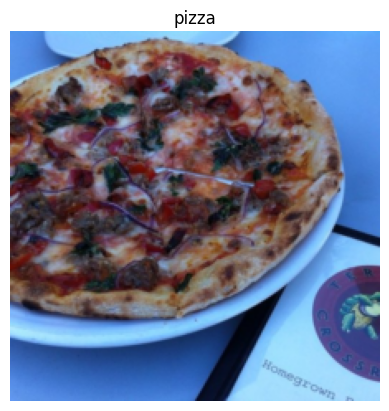

In [11]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
image.shape

torch.Size([3, 224, 224])

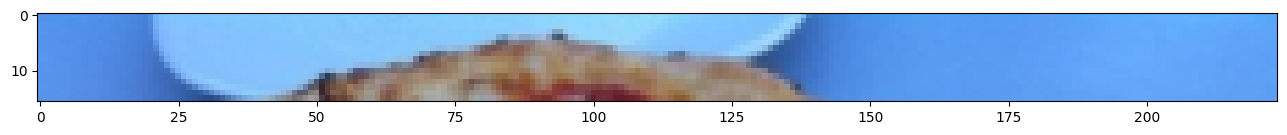

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert image to HWC

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : , :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


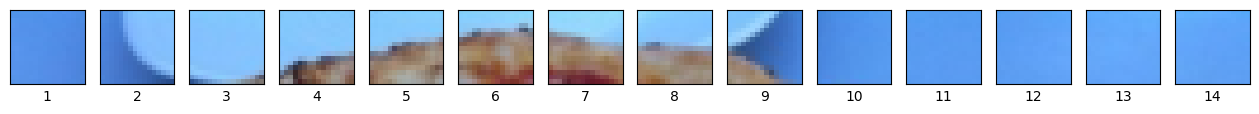

In [19]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisable by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size, # one colum per patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

# Loop through each subplot
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]) # (height, width, color_channels)
  axis[i].set_xlabel(i+1) # Set patch label
  axis[i].set_xticks([])
  axis[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


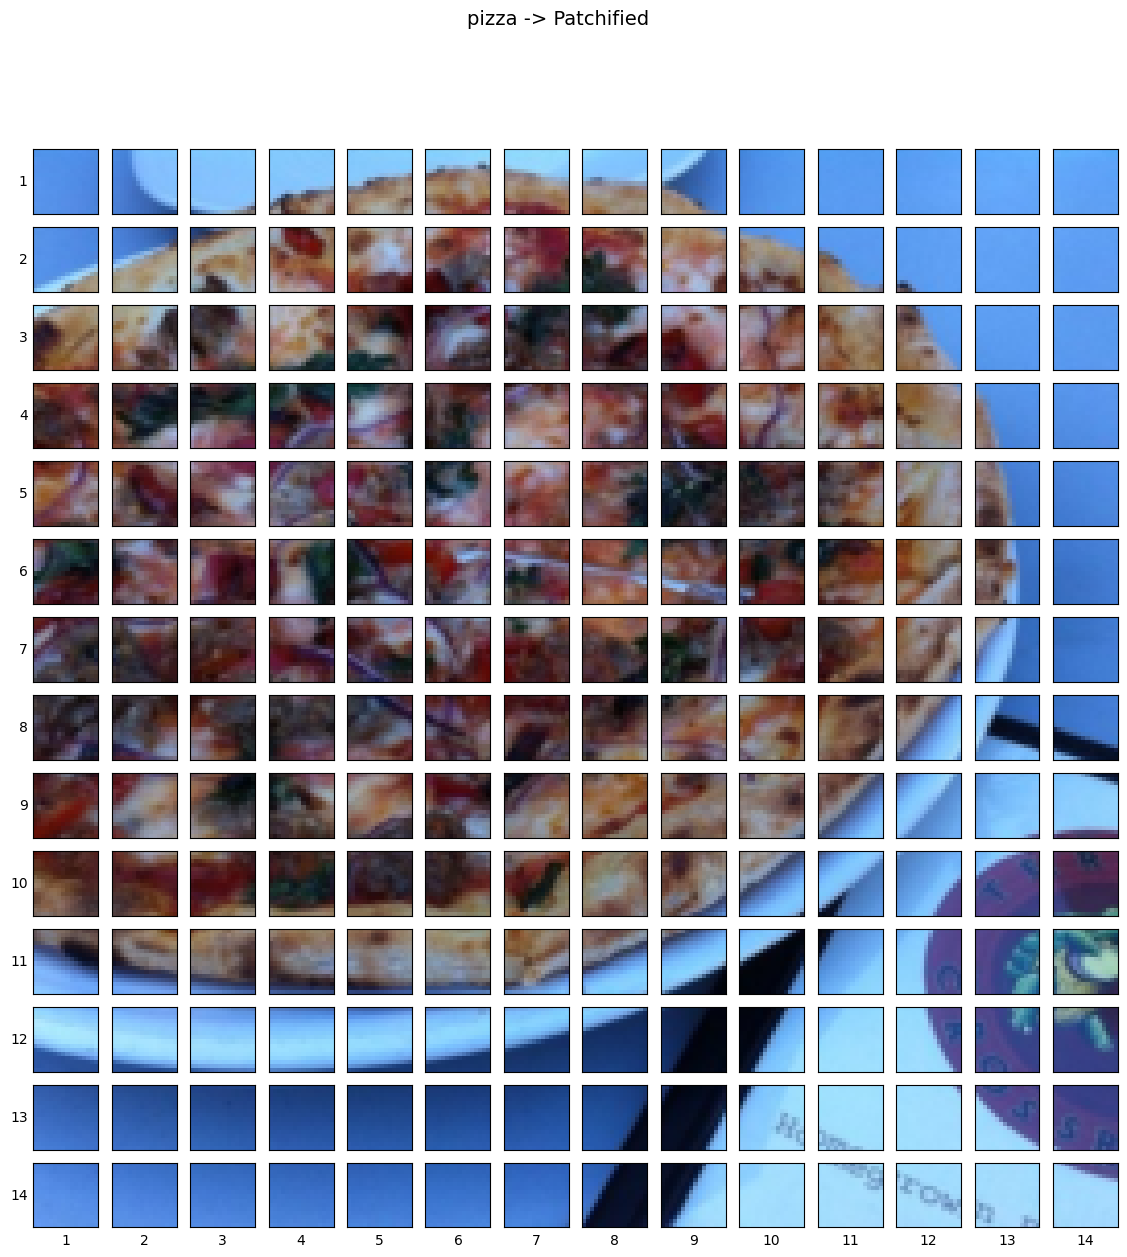

In [23]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches * num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=img_size // patch_size,
    ncols=img_size // patch_size,
    sharex=True,
    sharey=True,
    figsize=(num_patches, num_patches)
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
    axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]) # HWC

    # Setup label information
    axis[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
    axis[i, j].set_xlabel(j+1)
    axis[i, j].set_xticks([])
    axis[i, j].set_yticks([])
    axis[i, j].label_outer()

# Setup title
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=14)
plt.show()

### 4.3 Creating images patches and turning them into patch embeddings

Prehaps we could create the mage patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [25]:
# Create conv2d layer to turn image into patches of learnabe feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT architecture
conv2d = nn.Conv2d(
    in_channels=3, # for color channels
    out_channels=768, # D size from table 1
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

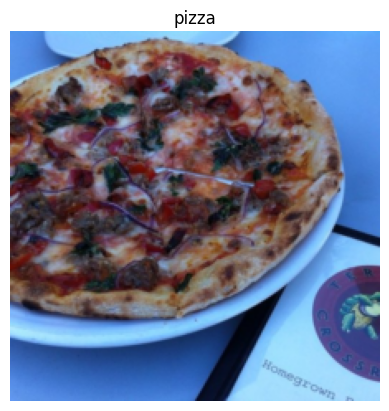

In [26]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [27]:
# Pass the image through the convolution layer
image_out_of_conv2d = conv2d(image.unsqueeze(0)) #Add batch dimenssion -> (batch_size, color_channels, height, width)
print(image_out_of_conv2d.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [513, 38, 144, 742, 90]


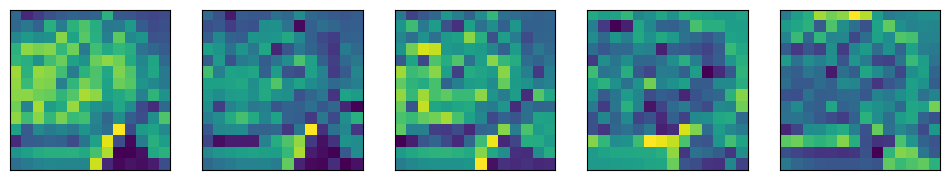

In [33]:
# plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create a series of subplot
fig, axis = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12, 12)
)

# Plot random image feature map
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv2d[:, idx, :, :] # Index on the output tensor
  axis[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove the batch dimension
  axis[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [34]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv2d[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad



(tensor([[[-0.8149, -0.9517, -1.0513, -0.9685, -0.9774, -0.9680, -1.0190,
           -0.9476, -0.6720, -0.8374, -0.8656, -0.8992, -0.9356, -0.9047],
          [-0.8339, -0.7926, -0.8335, -0.5204, -0.6820, -0.4598, -0.4490,
           -0.4585, -0.7324, -0.8685, -0.8056, -0.8593, -0.8997, -0.8889],
          [-0.5134, -0.5678, -0.5310, -0.6382, -0.2973, -0.4276, -0.2257,
           -0.4142, -0.6763, -0.6305, -0.7234, -0.8160, -0.8728, -0.8665],
          [-0.2977, -0.2513, -0.2577, -0.2797, -0.4458, -0.3685, -0.7223,
           -0.5098, -0.5155, -0.6840, -0.5406, -0.6651, -0.7671, -0.8409],
          [-0.7204, -0.4478, -0.4665, -0.5983, -0.3495, -0.4287, -0.6187,
           -0.3873, -0.2717, -0.2724, -0.5149, -0.6976, -0.6537, -0.7778],
          [-0.2492, -0.5782, -0.4523, -0.2753, -0.2394, -0.5746, -0.4334,
           -0.5838, -0.5446, -0.2484, -0.4083, -0.6363, -0.6902, -0.7088],
          [-0.3997, -0.4241, -0.3458, -0.3558, -0.4703, -0.5215, -0.4234,
           -0.3555, -0.2191, -0.

### 4.4 Flattening the patch embedding with `nn.Flatten()`

In [37]:
# torch.Size([1, 768, 14, 14]) => (batch_size, emdbedding_dim, feature_map_height, feature_map_width)

# Flatten to sequence
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flattened_image = flatten_layer(image_out_of_conv2d)
flattened_image.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature maps (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


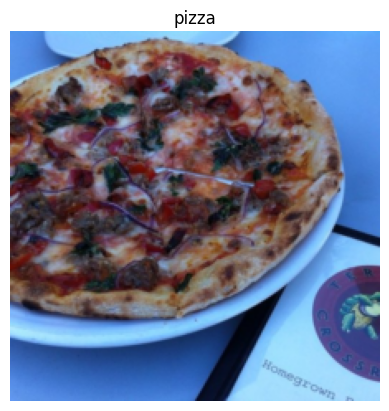

In [40]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv2d = conv2d(image.unsqueeze(0)) #Add batch dimenssion -> (batch_size, color_channels, height, width)
print(f"Image feature maps (patches) shape: {image_out_of_conv2d.shape}")

# Flatten the feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv2d)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [55]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


(-0.5, 195.5, 0.5, -0.5)

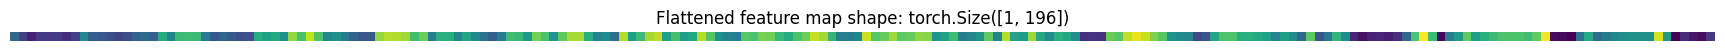

In [57]:
# Visualizing a single flattened patch embeddings vector

single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map.shape

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)